In [1]:
# mostly pulled from hls4ml_3.ipynb and waveform_demo.ipynb
# last updated 2025-05-06 by mza
name = "mza_try6"
num_epochs = 10000
batch_size = 1000
hidden_nodes = [ 64 ]
hidden_node_type = "relu"
truths_to_use = [ 0 ] # t_peak, t_sigma, height, pedestal
use_pruning = False
prune_ratio = 0.1
train = True
synth_hls = True
integer_part = 1
input_quantization = 14
inner_quantization = 14
output_quantization = 14

In [2]:
import os, errno
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['PATH'] = os.environ['XILINX_VIVADO'] + '/bin:' + os.environ['PATH']
import numpy as np
seed = 0
np.random.seed(seed)
import matplotlib.pyplot as plt
try:
    os.mkdir(name)
except OSError as exception:
    if exception.errno != errno.EEXIST:
        raise

In [3]:
dataset1 = np.load('waveform_data_0.npy') # (10000, 104)
dataset2 = np.load('waveform_data_1.npy') # (10000, 104)
dataset = np.concatenate((dataset1, dataset2))
num_waveforms = len(dataset)
training_quantity = int(0.8 * num_waveforms)
num_truths = 4
time_samples = len(dataset[0]) - num_truths
print("num_waveforms: " + str(num_waveforms))
num_truths_to_use = len(truths_to_use)
print("num_truths_to_use: " + str(num_truths_to_use))
waveforms = dataset[:,num_truths:]
truths = dataset[:,:num_truths]
waveform_min = min([ min(waveforms[i]) for i in range(len(waveforms)) ])
waveform_max = max([ max(waveforms[i]) for i in range(len(waveforms)) ])
offset = waveform_min
gain = 1.0 / (waveform_max - waveform_min)
scaled_waveforms = np.array([ [ gain * (waveforms[j,i] - offset) for i in range(time_samples) ] for j in range(num_waveforms) ])
scaled_truths = np.array([ [ truths[j,0]/time_samples, truths[j,1]/time_samples, gain * (truths[j,2] - offset), gain * (truths[j,3] - offset) ] for j in range(num_waveforms) ])
train_data = scaled_waveforms[:training_quantity,:]
print("train_data.shape: " + str(train_data.shape))
train_truth = scaled_truths[:training_quantity,truths_to_use]
print("train_truth.shape: " + str(train_truth.shape))
test_data = scaled_waveforms[training_quantity:,:]
print("test_data.shape: " + str(test_data.shape))
test_truth = scaled_truths[training_quantity:,truths_to_use]
print("test_truth.shape: " + str(test_truth.shape))

num_waveforms: 20000
num_truths_to_use: 1
train_data.shape: (16000, 100)
train_truth.shape: (16000, 1)
test_data.shape: (4000, 100)
test_truth.shape: (4000, 1)


In [4]:
evt = 8
if 0:
    x = np.zeros(time_samples)
    for i in range(time_samples):
        x[i] = i/time_samples
    y = train_data[evt]
    plt.xlim(0, 1), plt.ylim(0, 1)
    plt.scatter(x, y)
    plt.plot([train_truth[evt][0], train_truth[evt][0]], [0.0, 1.0], color="green")
    plt.show()

In [5]:
print("time position of the peak: ", train_truth[evt][0]) # The 0th column: mean of the Gaussian peak

time position of the peak:  0.6038360595703125


In [6]:
import tensorflow as tf
tf.random.set_seed(seed)
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l1
from tensorflow.keras.layers import Activation
from tensorflow.keras import optimizers
from callbacks import all_callbacks
from qkeras.qlayers import QDense, QActivation
from qkeras.quantizers import quantized_bits, quantized_relu, quantized_sigmoid

In [7]:
input_quantizer = quantized_bits(input_quantization, integer_part, alpha=1)
inner_quantizer = quantized_bits(inner_quantization, integer_part, alpha=1)
output_quantizer = quantized_bits(output_quantization, integer_part, alpha=1)
output_quantization_string = 'ap_fixed<' + str(output_quantization) + ',' + str(integer_part) + '>'
if hidden_node_type=="relu":
    hidden_activations = [ quantized_relu(inner_quantization) for i in range(len(hidden_nodes)) ]
else:
    hidden_activations = [ quantized_sigmoid(inner_quantization) for i in range(len(hidden_nodes)) ]
hidden_names = [ hidden_node_type for i in range(len(hidden_nodes)) ]
model = Sequential()
model.add(QDense(time_samples, input_shape=(time_samples,), name='input_qdense', kernel_quantizer=input_quantizer, bias_quantizer=input_quantizer, kernel_initializer='glorot_uniform'))
model.add(QActivation(activation=quantized_sigmoid(input_quantization), name='input_sigmoid'))
for i in range(len(hidden_nodes)):
    model.add(QDense(hidden_nodes[i], name=hidden_names[i] + str(i) + "qdense", kernel_quantizer=inner_quantizer, bias_quantizer=inner_quantizer, kernel_initializer='glorot_uniform'))
    model.add(QActivation(activation=hidden_activations[i], name=hidden_names[i] + str(i) + "activation"))
model.add(QDense(num_truths_to_use, name='output_qdense', kernel_quantizer=output_quantizer, bias_quantizer=output_quantizer, kernel_initializer='glorot_uniform'))
if num_truths_to_use<2:
    model.add(Activation(activation='sigmoid', name='output_sigmoid'))
else:
    model.add(Activation(activation='softmax', name='output_softmax'))

In [8]:
if use_pruning:
    from tensorflow_model_optimization.python.core.sparsity.keras import prune, pruning_callbacks, pruning_schedule
    from tensorflow_model_optimization.sparsity.keras import strip_pruning
    # the first argument is the percentage of the weights that will be forced to be 0
    pruning_params = {"pruning_schedule": pruning_schedule.ConstantSparsity(prune_ratio, begin_step=2000, frequency=100)}
    model = prune.prune_low_magnitude(model, **pruning_params)

In [9]:
if train:
    #optimizer = optimizers.Adam(learning_rate=0.0001)
    optimizer = optimizers.SGD(learning_rate=0.1)
    #model.compile(optimizer=optimizer, loss=['categorical_crossentropy'], metrics=['accuracy'])
    model.compile(optimizer=optimizer, loss=['mse'])
    if use_pruning:
        callbacks = all_callbacks(stop_patience=1000, lr_factor=0.5, lr_patience=10, lr_epsilon=0.000001, lr_cooldown=2, lr_minimum=0.0000001, outputDir=name)
        callbacks.callbacks.append(pruning_callbacks.UpdatePruningStep())
        model.fit(train_data, train_truth, batch_size=batch_size, epochs=num_epochs, validation_split=0.25, shuffle=False, callbacks=callbacks.callbacks, verbose=0)
    else:
        model.fit(train_data, train_truth, batch_size=batch_size, epochs=num_epochs, validation_split=0.25, shuffle=False, verbose=0)
    #loss, acc = model.evaluate(test_data, test_truth, verbose=0)
    if use_pruning:
        model = strip_pruning(model)
    model.save(name + '/KERAS_check_best_model.keras')
else:
    from tensorflow.keras.models import load_model
    from qkeras.utils import _add_supported_quantized_objects
    co = {}
    _add_supported_quantized_objects(co)
    model = load_model(name + '/KERAS_check_best_model.keras', custom_objects=co) # TypeError: <qkeras.qlayers.QActivation object at 0x774300567100> could not be deserialized properly. Please ensure that components that are Python object instances (layers, models, etc.) returned by `get_config()` are explicitly deserialized in the model's `from_config()` method.

/root/anaconda3/envs/hls4ml-tutorial/lib/python3.10/site-packages/keras/src/constraints.py:365: UserWarning: The `keras.constraints.serialize()` API should only be used for objects of type `keras.constraints.Constraint`. Found an instance of type <class 'qkeras.quantizers.quantized_bits'>, which may lead to improper serialization.
  warnings.warn(


In [10]:
#print('test_acc: {:.3f}, test_loss: {:.3f}'.format(acc, loss))
train_prediction = model.predict(train_data)
test_prediction = model.predict(test_data)

125/125 [==============================] - 0s 722us/step


In [11]:
evt = 5
if 0:
    print(str(test_prediction[evt]) + " : " + str(test_truth[evt]))
    x = np.zeros(time_samples)
    for i in range(time_samples):
        x[i] = i/time_samples
    y = test_data[evt]
    plt.xlim(0, 1); plt.ylim(0, 1)
    plt.scatter(x, y, color="blue")
    plt.plot([test_prediction[evt,0], test_prediction[evt,0]], [0.0, 1.0], color="red")
    plt.plot([test_truth[evt,0], test_truth[evt,0]], [0.0, 1.0], color="green")
    plt.show()

In [12]:
import csv
with open(name + '/Input.dat', 'w') as f:
    csv.writer(f, delimiter=' ').writerows(test_data)
with open(name + '/Output.dat', 'w') as f:
    csv.writer(f, delimiter=' ').writerows(test_prediction)

In [13]:
import hls4ml, plotting
config = hls4ml.utils.config_from_keras_model(model, granularity='name', default_reuse_factor=10)
config['LayerName']['output_sigmoid']['exp_table_t'] = output_quantization_string
config['LayerName']['output_sigmoid']['inv_table_t'] = output_quantization_string
config['LayerName']['output_sigmoid']['Precision']   = output_quantization_string
plotting.print_dict(config)
hls_model = hls4ml.converters.convert_from_keras_model(
    model, hls_config=config, output_dir=name + '/hls4ml_prj', part='xc7z020clg400-1',
    input_data_tb = name + "/Input.dat", output_data_tb = name + "/Output.dat", backend='Vitis', verbose=0
)

Interpreting Sequential
Topology:
Layer name: input_qdense_input, layer type: InputLayer, input shapes: [[None, 100]], output shape: [None, 100]
Layer name: input_qdense, layer type: QDense, input shapes: [[None, 100]], output shape: [None, 100]
Layer name: input_sigmoid, layer type: HardActivation, input shapes: [[None, 100]], output shape: [None, 100]
Layer name: relu0qdense, layer type: QDense, input shapes: [[None, 100]], output shape: [None, 64]
Layer name: relu0activation, layer type: Activation, input shapes: [[None, 64]], output shape: [None, 64]
Layer name: output_qdense, layer type: QDense, input shapes: [[None, 64]], output shape: [None, 1]
Layer name: output_sigmoid, layer type: Activation, input shapes: [[None, 1]], output shape: [None, 1]
Model
  Precision
    default:         fixed<16,6>
  ReuseFactor:       10
  Strategy:          Latency
  BramFactor:        1000000000
  TraceOutput:       False
LayerName
  input_qdense_input
    Trace:           False
    Precision
  

/root/anaconda3/envs/hls4ml-tutorial/lib/python3.10/site-packages/keras/src/constraints.py:365: UserWarning: The `keras.constraints.serialize()` API should only be used for objects of type `keras.constraints.Constraint`. Found an instance of type <class 'qkeras.quantizers.quantized_bits'>, which may lead to improper serialization.
  warnings.warn(


In [14]:
from IPython.display import Image
hls4ml.utils.plot_model(hls_model, show_shapes=True, show_precision=True, to_file=name + '/hls_model.png')
#Image(name + '/hls_model.png')

In [15]:
hls_model.compile()

/root/anaconda3/envs/hls4ml-tutorial/lib/python3.10/site-packages/keras/src/constraints.py:365: UserWarning: The `keras.constraints.serialize()` API should only be used for objects of type `keras.constraints.Constraint`. Found an instance of type <class 'qkeras.quantizers.quantized_bits'>, which may lead to improper serialization.
  warnings.warn(


Writing HLS project
Done


In [16]:
hls_train_prediction = hls_model.predict(np.ascontiguousarray(train_data))
hls_test_prediction = hls_model.predict(np.ascontiguousarray(test_data))

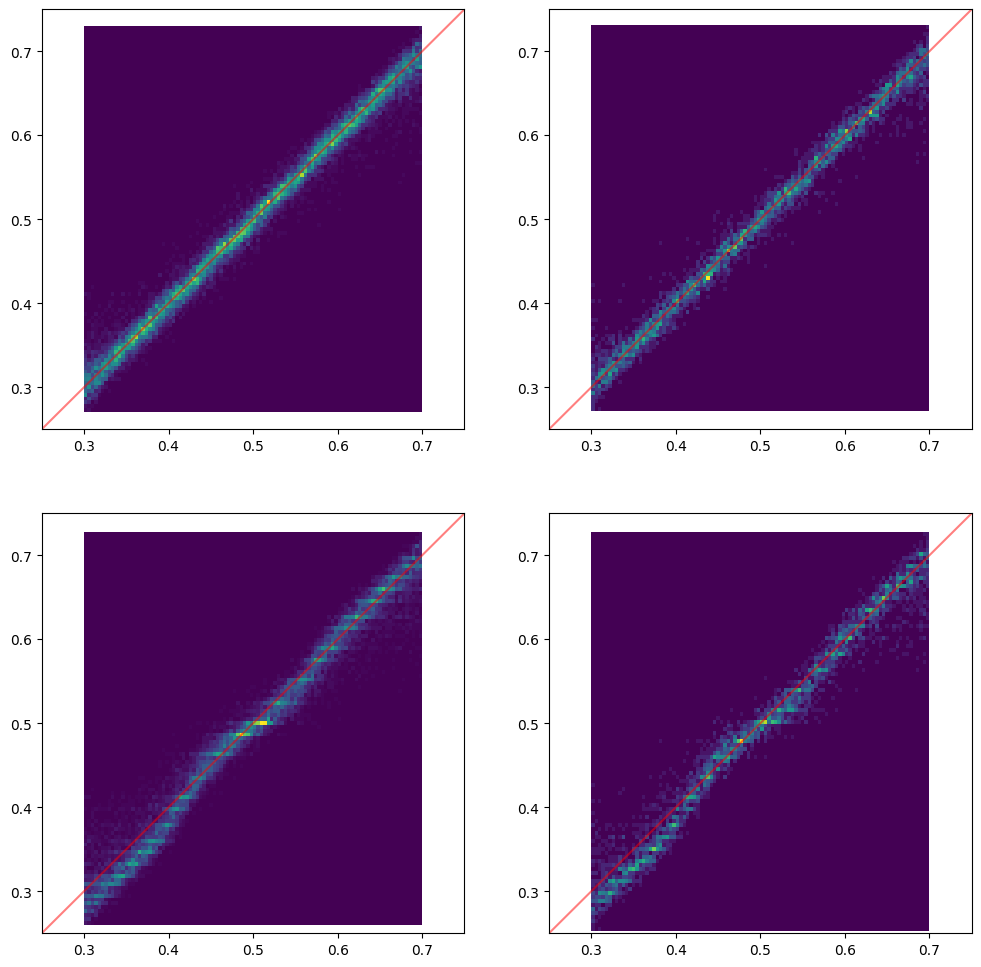

In [17]:
nbins = 100
a = 0.25; b = 0.75
for i in range(num_truths_to_use):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(12,12))
    ax1.hist2d(train_truth[:,i].ravel(), train_prediction[:,i].ravel(),     bins=nbins); ax1.plot([0.0, 1.0], [0.0, 1.0], color="red", alpha=0.5); ax1.set_xlim(a, b); ax1.set_ylim(a, b)
    ax2.hist2d(test_truth[:,i].ravel(),  test_prediction[:,i].ravel(),      bins=nbins); ax2.plot([0.0, 1.0], [0.0, 1.0], color="red", alpha=0.5); ax2.set_xlim(a, b); ax2.set_ylim(a, b)
    ax3.hist2d(train_truth[:,i].ravel(), hls_train_prediction[:,i].ravel(), bins=nbins); ax3.plot([0.0, 1.0], [0.0, 1.0], color="red", alpha=0.5); ax3.set_xlim(a, b); ax3.set_ylim(a, b)
    ax4.hist2d(test_truth[:,i].ravel(),  hls_test_prediction[:,i].ravel(),  bins=nbins); ax4.plot([0.0, 1.0], [0.0, 1.0], color="red", alpha=0.5); ax4.set_xlim(a, b); ax4.set_ylim(a, b)
    plt.show()
    fig.savefig(name + "/hist2d." + str(truths_to_use[i]) + ".png")

In [18]:
if synth_hls:
    hls_model.build(synth=True, csim=True, cosim=True)


****** Vitis HLS - High-Level Synthesis from C, C++ and OpenCL v2023.1 (64-bit)
  **** SW Build 3854077 on May  4 2023
  **** IP Build 3864474 on Sun May  7 20:36:21 MDT 2023
  **** SharedData Build 3865790 on Sun May 07 13:33:03 MDT 2023
    ** Copyright 1986-2022 Xilinx, Inc. All Rights Reserved.
    ** Copyright 2022-2023 Advanced Micro Devices, Inc. All Rights Reserved.

source /opt/Xilinx/Vitis_HLS/2023.1/scripts/vitis_hls/hls.tcl -notrace
INFO: [HLS 200-10] Running '/opt/Xilinx/Vitis_HLS/2023.1/bin/unwrapped/lnx64.o/vitis_hls'
INFO: [HLS 200-10] For user 'root' on host '17425374c219' (Linux_x86_64 version 6.11.0-21-generic) on Tue May 06 14:00:45 EDT 2025
INFO: [HLS 200-10] In directory '/root/build/phys476/final_project/waveform_dataset/mza_try6/hls4ml_prj'
Sourcing Tcl script 'build_prj.tcl'
INFO: [HLS 200-1510] Running: open_project myproject_prj 
INFO: [HLS 200-10] Opening project '/root/build/phys476/final_project/waveform_dataset/mza_try6/hls4ml_prj/myproject_prj'.
INFO: [

INFO: [HLS 214-131] Inlining function 'nnet::product::mult<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<14, 2, (ap_q_mode)5, (ap_o_mode)3, 0> >::product(ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<14, 2, (ap_q_mode)5, (ap_o_mode)3, 0>)' into 'void nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<38, 16, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>(ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>*, ap_fixed<38, 16, (ap_q_mode)5, (ap_o_mode)3, 0>*, config2::weight_t*, config2::bias_t*)' (firmware/nnet_utils/nnet_dense_latency.h:42:27)
INFO: [HLS 214-131] Inlining function 'nnet::DenseLatency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<38, 16, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>::dense(ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>*, ap_fixed<38, 16, (ap_q_mode)5, (ap_o_mode)3, 0>*, ap_fixed<14, 2, (ap_q_mode)5, (ap_o_mode)3, 0>*, ap_fixed<14, 2, (ap_q_mode)5, (ap_o_mode)3, 0>*)' into 'void nnet::dense<ap_fixed<16, 6, (ap_q_

INFO: [HLS 200-111] Finished Standard Transforms: CPU user time: 8.73 seconds. CPU system time: 0.09 seconds. Elapsed time: 8.83 seconds; current allocated memory: 1.231 GB.
INFO: [HLS 200-10] Checking synthesizability ...
INFO: [HLS 200-111] Finished Checking Synthesizability: CPU user time: 10.88 seconds. CPU system time: 0.01 seconds. Elapsed time: 10.89 seconds; current allocated memory: 1.215 GB.
INFO: [XFORM 203-602] Inlining function 'nnet::cast<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<38, 16, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>' into 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<38, 16, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>' (firmware/nnet_utils/nnet_dense_latency.h:66) automatically.
INFO: [XFORM 203-602] Inlining function 'nnet::cast<ap_ufixed<14, 0, (ap_q_mode)4, (ap_o_mode)0, 0>, ap_fixed<36, 10, (ap_q_mode)5, (ap_o_mode)3, 0>, config5>' into 'nnet::dense_latency<ap_ufixed<14, 0, (ap_q_mode)4, (ap_o_mode)0, 0>, ap_fixe

INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] -- Implementing module 'relu_ap_fixed_36_10_5_3_0_ap_ufixed_14_0_4_0_0_relu_config7_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SCHED 204-11] Starting scheduling ...
INFO: [SCHED 204-61] Pipelining function 'relu<ap_fixed<36, 10, 5, 3, 0>, ap_ufixed<14, 0, 4, 0, 0>, relu_config7>'.
INFO: [HLS 200-1470] Pipelining result : Target II = NA, Final II = 1, Depth = 2, function 'relu<ap_fixed<36, 10, 5, 3, 0>, ap_ufixed<14, 0, 4, 0, 0>, relu_config7>'
INFO: [SCHED 204-11] Finished scheduling.
INFO: [HLS 200-111] Finished Scheduling: CPU user time: 4.37 seconds. CPU system time: 0.07 seconds. Elapsed time: 4.43 seconds; current allocated memory: 3.334 GB.
INFO: [BIND 205-100] Starting micro-architecture generation ...
INFO: [BIND 205-101] Performing variable lifetime analysis.
INFO: [BIND 205-101] Exploring resource sharing.
INFO: [BIND 205-1

INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'relu_ap_fixed_36_10_5_3_0_ap_ufixed_14_0_4_0_0_relu_config7_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-100] Finished creating RTL model for 'relu_ap_fixed_36_10_5_3_0_ap_ufixed_14_0_4_0_0_relu_config7_s'.
INFO: [HLS 200-111] Finished Creating RTL model: CPU user time: 47.42 seconds. CPU system time: 0.81 seconds. Elapsed time: 48.28 seconds; current allocated memory: 5.009 GB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'dense_latency_ap_ufixed_14_0_4_0_0_ap_fixed_35_9_5_3_0_config8_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-1030] Apply Unified Pipeline Control on module 'dense_latency_ap_ufixed_14_0_4_0_0_ap_fixed_35_9_5_3_0_config8_s' pipeline 'de

INFO: [VRFC 10-2263] Analyzing SystemVerilog file "/root/build/phys476/final_project/waveform_dataset/mza_try6/hls4ml_prj/myproject_prj/solution1/sim/verilog/myproject_mul_14ns_9s_22_2_1.v" into library xil_defaultlib
INFO: [VRFC 10-311] analyzing module myproject_mul_14ns_9s_22_2_1
INFO: [VRFC 10-2263] Analyzing SystemVerilog file "/root/build/phys476/final_project/waveform_dataset/mza_try6/hls4ml_prj/myproject_prj/solution1/sim/verilog/myproject_dense_latency_ap_ufixed_14_0_4_0_0_ap_fixed_36_10_5_3_0_config5_s.v" into library xil_defaultlib
INFO: [VRFC 10-311] analyzing module myproject_dense_latency_ap_ufixed_14_0_4_0_0_ap_fixed_36_10_5_3_0_config5_s
INFO: [VRFC 10-2263] Analyzing SystemVerilog file "/root/build/phys476/final_project/waveform_dataset/mza_try6/hls4ml_prj/myproject_prj/solution1/sim/verilog/myproject_mul_14ns_13s_27_2_1.v" into library xil_defaultlib
INFO: [VRFC 10-311] analyzing module myproject_mul_14ns_13s_27_2_1
INFO: [VRFC 10-2263] Analyzing SystemVerilog file "/

// RTL Simulation : 1 / 4000 [81.48%] @ "393000"
// RTL Simulation : 2 / 4000 [81.48%] @ "443000"
// RTL Simulation : 3 / 4000 [81.48%] @ "493000"
// RTL Simulation : 4 / 4000 [81.48%] @ "543000"
// RTL Simulation : 5 / 4000 [81.48%] @ "593000"
// RTL Simulation : 6 / 4000 [81.48%] @ "643000"
// RTL Simulation : 7 / 4000 [81.48%] @ "693000"
// RTL Simulation : 8 / 4000 [81.48%] @ "743000"
// RTL Simulation : 9 / 4000 [81.48%] @ "793000"
// RTL Simulation : 10 / 4000 [81.48%] @ "843000"
// RTL Simulation : 11 / 4000 [81.48%] @ "893000"
// RTL Simulation : 12 / 4000 [81.48%] @ "943000"
// RTL Simulation : 13 / 4000 [81.48%] @ "993000"
// RTL Simulation : 14 / 4000 [81.48%] @ "1043000"
// RTL Simulation : 15 / 4000 [81.48%] @ "1093000"
// RTL Simulation : 16 / 4000 [81.48%] @ "1143000"
// RTL Simulation : 17 / 4000 [81.48%] @ "1193000"
// RTL Simulation : 18 / 4000 [81.48%] @ "1243000"
// RTL Simulation : 19 / 4000 [81.48%] @ "1293000"
// RTL Simulation : 20 / 4000 [81.48%] @ "1343000"
//

// RTL Simulation : 163 / 4000 [81.48%] @ "8493000"
// RTL Simulation : 164 / 4000 [81.48%] @ "8543000"
// RTL Simulation : 165 / 4000 [81.48%] @ "8593000"
// RTL Simulation : 166 / 4000 [81.48%] @ "8643000"
// RTL Simulation : 167 / 4000 [81.48%] @ "8693000"
// RTL Simulation : 168 / 4000 [81.48%] @ "8743000"
// RTL Simulation : 169 / 4000 [81.48%] @ "8793000"
// RTL Simulation : 170 / 4000 [81.48%] @ "8843000"
// RTL Simulation : 171 / 4000 [81.48%] @ "8893000"
// RTL Simulation : 172 / 4000 [81.48%] @ "8943000"
// RTL Simulation : 173 / 4000 [81.48%] @ "8993000"
// RTL Simulation : 174 / 4000 [81.48%] @ "9043000"
// RTL Simulation : 175 / 4000 [81.48%] @ "9093000"
// RTL Simulation : 176 / 4000 [81.48%] @ "9143000"
// RTL Simulation : 177 / 4000 [81.48%] @ "9193000"
// RTL Simulation : 178 / 4000 [81.48%] @ "9243000"
// RTL Simulation : 179 / 4000 [81.48%] @ "9293000"
// RTL Simulation : 180 / 4000 [81.48%] @ "9343000"
// RTL Simulation : 181 / 4000 [81.48%] @ "9393000"
// RTL Simul

// RTL Simulation : 319 / 4000 [81.48%] @ "16293000"
// RTL Simulation : 320 / 4000 [81.48%] @ "16343000"
// RTL Simulation : 321 / 4000 [81.48%] @ "16393000"
// RTL Simulation : 322 / 4000 [81.48%] @ "16443000"
// RTL Simulation : 323 / 4000 [81.48%] @ "16493000"
// RTL Simulation : 324 / 4000 [81.48%] @ "16543000"
// RTL Simulation : 325 / 4000 [81.48%] @ "16593000"
// RTL Simulation : 326 / 4000 [81.48%] @ "16643000"
// RTL Simulation : 327 / 4000 [81.48%] @ "16693000"
// RTL Simulation : 328 / 4000 [81.48%] @ "16743000"
// RTL Simulation : 329 / 4000 [81.48%] @ "16793000"
// RTL Simulation : 330 / 4000 [81.48%] @ "16843000"
// RTL Simulation : 331 / 4000 [81.48%] @ "16893000"
// RTL Simulation : 332 / 4000 [81.48%] @ "16943000"
// RTL Simulation : 333 / 4000 [81.48%] @ "16993000"
// RTL Simulation : 334 / 4000 [81.48%] @ "17043000"
// RTL Simulation : 335 / 4000 [81.48%] @ "17093000"
// RTL Simulation : 336 / 4000 [81.48%] @ "17143000"
// RTL Simulation : 337 / 4000 [81.48%] @ "171

// RTL Simulation : 475 / 4000 [81.48%] @ "24093000"
// RTL Simulation : 476 / 4000 [81.48%] @ "24143000"
// RTL Simulation : 477 / 4000 [81.48%] @ "24193000"
// RTL Simulation : 478 / 4000 [81.48%] @ "24243000"
// RTL Simulation : 479 / 4000 [81.48%] @ "24293000"
// RTL Simulation : 480 / 4000 [81.48%] @ "24343000"
// RTL Simulation : 481 / 4000 [81.48%] @ "24393000"
// RTL Simulation : 482 / 4000 [81.48%] @ "24443000"
// RTL Simulation : 483 / 4000 [81.48%] @ "24493000"
// RTL Simulation : 484 / 4000 [81.48%] @ "24543000"
// RTL Simulation : 485 / 4000 [81.48%] @ "24593000"
// RTL Simulation : 486 / 4000 [81.48%] @ "24643000"
// RTL Simulation : 487 / 4000 [81.48%] @ "24693000"
// RTL Simulation : 488 / 4000 [81.48%] @ "24743000"
// RTL Simulation : 489 / 4000 [81.48%] @ "24793000"
// RTL Simulation : 490 / 4000 [81.48%] @ "24843000"
// RTL Simulation : 491 / 4000 [81.48%] @ "24893000"
// RTL Simulation : 492 / 4000 [81.48%] @ "24943000"
// RTL Simulation : 493 / 4000 [81.48%] @ "249

// RTL Simulation : 631 / 4000 [81.48%] @ "31893000"
// RTL Simulation : 632 / 4000 [81.48%] @ "31943000"
// RTL Simulation : 633 / 4000 [81.48%] @ "31993000"
// RTL Simulation : 634 / 4000 [81.48%] @ "32043000"
// RTL Simulation : 635 / 4000 [81.48%] @ "32093000"
// RTL Simulation : 636 / 4000 [81.48%] @ "32143000"
// RTL Simulation : 637 / 4000 [81.48%] @ "32193000"
// RTL Simulation : 638 / 4000 [81.48%] @ "32243000"
// RTL Simulation : 639 / 4000 [81.48%] @ "32293000"
// RTL Simulation : 640 / 4000 [81.48%] @ "32343000"
// RTL Simulation : 641 / 4000 [81.48%] @ "32393000"
// RTL Simulation : 642 / 4000 [81.48%] @ "32443000"
// RTL Simulation : 643 / 4000 [81.48%] @ "32493000"
// RTL Simulation : 644 / 4000 [81.48%] @ "32543000"
// RTL Simulation : 645 / 4000 [81.48%] @ "32593000"
// RTL Simulation : 646 / 4000 [81.48%] @ "32643000"
// RTL Simulation : 647 / 4000 [81.48%] @ "32693000"
// RTL Simulation : 648 / 4000 [81.48%] @ "32743000"
// RTL Simulation : 649 / 4000 [81.48%] @ "327

// RTL Simulation : 787 / 4000 [81.48%] @ "39693000"
// RTL Simulation : 788 / 4000 [81.48%] @ "39743000"
// RTL Simulation : 789 / 4000 [81.48%] @ "39793000"
// RTL Simulation : 790 / 4000 [81.48%] @ "39843000"
// RTL Simulation : 791 / 4000 [81.48%] @ "39893000"
// RTL Simulation : 792 / 4000 [81.48%] @ "39943000"
// RTL Simulation : 793 / 4000 [81.48%] @ "39993000"
// RTL Simulation : 794 / 4000 [81.48%] @ "40043000"
// RTL Simulation : 795 / 4000 [81.48%] @ "40093000"
// RTL Simulation : 796 / 4000 [81.48%] @ "40143000"
// RTL Simulation : 797 / 4000 [81.48%] @ "40193000"
// RTL Simulation : 798 / 4000 [81.48%] @ "40243000"
// RTL Simulation : 799 / 4000 [81.48%] @ "40293000"
// RTL Simulation : 800 / 4000 [81.48%] @ "40343000"
// RTL Simulation : 801 / 4000 [81.48%] @ "40393000"
// RTL Simulation : 802 / 4000 [81.48%] @ "40443000"
// RTL Simulation : 803 / 4000 [81.48%] @ "40493000"
// RTL Simulation : 804 / 4000 [81.48%] @ "40543000"
// RTL Simulation : 805 / 4000 [81.48%] @ "405

// RTL Simulation : 943 / 4000 [81.48%] @ "47493000"
// RTL Simulation : 944 / 4000 [81.48%] @ "47543000"
// RTL Simulation : 945 / 4000 [81.48%] @ "47593000"
// RTL Simulation : 946 / 4000 [81.48%] @ "47643000"
// RTL Simulation : 947 / 4000 [81.48%] @ "47693000"
// RTL Simulation : 948 / 4000 [81.48%] @ "47743000"
// RTL Simulation : 949 / 4000 [81.48%] @ "47793000"
// RTL Simulation : 950 / 4000 [81.48%] @ "47843000"
// RTL Simulation : 951 / 4000 [81.48%] @ "47893000"
// RTL Simulation : 952 / 4000 [81.48%] @ "47943000"
// RTL Simulation : 953 / 4000 [81.48%] @ "47993000"
// RTL Simulation : 954 / 4000 [81.48%] @ "48043000"
// RTL Simulation : 955 / 4000 [81.48%] @ "48093000"
// RTL Simulation : 956 / 4000 [81.48%] @ "48143000"
// RTL Simulation : 957 / 4000 [81.48%] @ "48193000"
// RTL Simulation : 958 / 4000 [81.48%] @ "48243000"
// RTL Simulation : 959 / 4000 [81.48%] @ "48293000"
// RTL Simulation : 960 / 4000 [81.48%] @ "48343000"
// RTL Simulation : 961 / 4000 [81.48%] @ "483

// RTL Simulation : 1096 / 4000 [81.48%] @ "55143000"
// RTL Simulation : 1097 / 4000 [81.48%] @ "55193000"
// RTL Simulation : 1098 / 4000 [81.48%] @ "55243000"
// RTL Simulation : 1099 / 4000 [81.48%] @ "55293000"
// RTL Simulation : 1100 / 4000 [81.48%] @ "55343000"
// RTL Simulation : 1101 / 4000 [81.48%] @ "55393000"
// RTL Simulation : 1102 / 4000 [81.48%] @ "55443000"
// RTL Simulation : 1103 / 4000 [81.48%] @ "55493000"
// RTL Simulation : 1104 / 4000 [81.48%] @ "55543000"
// RTL Simulation : 1105 / 4000 [81.48%] @ "55593000"
// RTL Simulation : 1106 / 4000 [81.48%] @ "55643000"
// RTL Simulation : 1107 / 4000 [81.48%] @ "55693000"
// RTL Simulation : 1108 / 4000 [81.48%] @ "55743000"
// RTL Simulation : 1109 / 4000 [81.48%] @ "55793000"
// RTL Simulation : 1110 / 4000 [81.48%] @ "55843000"
// RTL Simulation : 1111 / 4000 [81.48%] @ "55893000"
// RTL Simulation : 1112 / 4000 [81.48%] @ "55943000"
// RTL Simulation : 1113 / 4000 [81.48%] @ "55993000"
// RTL Simulation : 1114 / 4

// RTL Simulation : 1249 / 4000 [81.48%] @ "62793000"
// RTL Simulation : 1250 / 4000 [81.48%] @ "62843000"
// RTL Simulation : 1251 / 4000 [81.48%] @ "62893000"
// RTL Simulation : 1252 / 4000 [81.48%] @ "62943000"
// RTL Simulation : 1253 / 4000 [81.48%] @ "62993000"
// RTL Simulation : 1254 / 4000 [81.48%] @ "63043000"
// RTL Simulation : 1255 / 4000 [81.48%] @ "63093000"
// RTL Simulation : 1256 / 4000 [81.48%] @ "63143000"
// RTL Simulation : 1257 / 4000 [81.48%] @ "63193000"
// RTL Simulation : 1258 / 4000 [81.48%] @ "63243000"
// RTL Simulation : 1259 / 4000 [81.48%] @ "63293000"
// RTL Simulation : 1260 / 4000 [81.48%] @ "63343000"
// RTL Simulation : 1261 / 4000 [81.48%] @ "63393000"
// RTL Simulation : 1262 / 4000 [81.48%] @ "63443000"
// RTL Simulation : 1263 / 4000 [81.48%] @ "63493000"
// RTL Simulation : 1264 / 4000 [81.48%] @ "63543000"
// RTL Simulation : 1265 / 4000 [81.48%] @ "63593000"
// RTL Simulation : 1266 / 4000 [81.48%] @ "63643000"
// RTL Simulation : 1267 / 4

// RTL Simulation : 1402 / 4000 [81.48%] @ "70443000"
// RTL Simulation : 1403 / 4000 [81.48%] @ "70493000"
// RTL Simulation : 1404 / 4000 [81.48%] @ "70543000"
// RTL Simulation : 1405 / 4000 [81.48%] @ "70593000"
// RTL Simulation : 1406 / 4000 [81.48%] @ "70643000"
// RTL Simulation : 1407 / 4000 [81.48%] @ "70693000"
// RTL Simulation : 1408 / 4000 [81.48%] @ "70743000"
// RTL Simulation : 1409 / 4000 [81.48%] @ "70793000"
// RTL Simulation : 1410 / 4000 [81.48%] @ "70843000"
// RTL Simulation : 1411 / 4000 [81.48%] @ "70893000"
// RTL Simulation : 1412 / 4000 [81.48%] @ "70943000"
// RTL Simulation : 1413 / 4000 [81.48%] @ "70993000"
// RTL Simulation : 1414 / 4000 [81.48%] @ "71043000"
// RTL Simulation : 1415 / 4000 [81.48%] @ "71093000"
// RTL Simulation : 1416 / 4000 [81.48%] @ "71143000"
// RTL Simulation : 1417 / 4000 [81.48%] @ "71193000"
// RTL Simulation : 1418 / 4000 [81.48%] @ "71243000"
// RTL Simulation : 1419 / 4000 [81.48%] @ "71293000"
// RTL Simulation : 1420 / 4

// RTL Simulation : 1555 / 4000 [81.48%] @ "78093000"
// RTL Simulation : 1556 / 4000 [81.48%] @ "78143000"
// RTL Simulation : 1557 / 4000 [81.48%] @ "78193000"
// RTL Simulation : 1558 / 4000 [81.48%] @ "78243000"
// RTL Simulation : 1559 / 4000 [81.48%] @ "78293000"
// RTL Simulation : 1560 / 4000 [81.48%] @ "78343000"
// RTL Simulation : 1561 / 4000 [81.48%] @ "78393000"
// RTL Simulation : 1562 / 4000 [81.48%] @ "78443000"
// RTL Simulation : 1563 / 4000 [81.48%] @ "78493000"
// RTL Simulation : 1564 / 4000 [81.48%] @ "78543000"
// RTL Simulation : 1565 / 4000 [81.48%] @ "78593000"
// RTL Simulation : 1566 / 4000 [81.48%] @ "78643000"
// RTL Simulation : 1567 / 4000 [81.48%] @ "78693000"
// RTL Simulation : 1568 / 4000 [81.48%] @ "78743000"
// RTL Simulation : 1569 / 4000 [81.48%] @ "78793000"
// RTL Simulation : 1570 / 4000 [81.48%] @ "78843000"
// RTL Simulation : 1571 / 4000 [81.48%] @ "78893000"
// RTL Simulation : 1572 / 4000 [81.48%] @ "78943000"
// RTL Simulation : 1573 / 4

// RTL Simulation : 1708 / 4000 [81.48%] @ "85743000"
// RTL Simulation : 1709 / 4000 [81.48%] @ "85793000"
// RTL Simulation : 1710 / 4000 [81.48%] @ "85843000"
// RTL Simulation : 1711 / 4000 [81.48%] @ "85893000"
// RTL Simulation : 1712 / 4000 [81.48%] @ "85943000"
// RTL Simulation : 1713 / 4000 [81.48%] @ "85993000"
// RTL Simulation : 1714 / 4000 [81.48%] @ "86043000"
// RTL Simulation : 1715 / 4000 [81.48%] @ "86093000"
// RTL Simulation : 1716 / 4000 [81.48%] @ "86143000"
// RTL Simulation : 1717 / 4000 [81.48%] @ "86193000"
// RTL Simulation : 1718 / 4000 [81.48%] @ "86243000"
// RTL Simulation : 1719 / 4000 [81.48%] @ "86293000"
// RTL Simulation : 1720 / 4000 [81.48%] @ "86343000"
// RTL Simulation : 1721 / 4000 [81.48%] @ "86393000"
// RTL Simulation : 1722 / 4000 [81.48%] @ "86443000"
// RTL Simulation : 1723 / 4000 [81.48%] @ "86493000"
// RTL Simulation : 1724 / 4000 [81.48%] @ "86543000"
// RTL Simulation : 1725 / 4000 [81.48%] @ "86593000"
// RTL Simulation : 1726 / 4

// RTL Simulation : 1861 / 4000 [81.48%] @ "93393000"
// RTL Simulation : 1862 / 4000 [81.48%] @ "93443000"
// RTL Simulation : 1863 / 4000 [81.48%] @ "93493000"
// RTL Simulation : 1864 / 4000 [81.48%] @ "93543000"
// RTL Simulation : 1865 / 4000 [81.48%] @ "93593000"
// RTL Simulation : 1866 / 4000 [81.48%] @ "93643000"
// RTL Simulation : 1867 / 4000 [81.48%] @ "93693000"
// RTL Simulation : 1868 / 4000 [81.48%] @ "93743000"
// RTL Simulation : 1869 / 4000 [81.48%] @ "93793000"
// RTL Simulation : 1870 / 4000 [81.48%] @ "93843000"
// RTL Simulation : 1871 / 4000 [81.48%] @ "93893000"
// RTL Simulation : 1872 / 4000 [81.48%] @ "93943000"
// RTL Simulation : 1873 / 4000 [81.48%] @ "93993000"
// RTL Simulation : 1874 / 4000 [81.48%] @ "94043000"
// RTL Simulation : 1875 / 4000 [81.48%] @ "94093000"
// RTL Simulation : 1876 / 4000 [81.48%] @ "94143000"
// RTL Simulation : 1877 / 4000 [81.48%] @ "94193000"
// RTL Simulation : 1878 / 4000 [81.48%] @ "94243000"
// RTL Simulation : 1879 / 4

// RTL Simulation : 2013 / 4000 [81.48%] @ "100993000"
// RTL Simulation : 2014 / 4000 [81.48%] @ "101043000"
// RTL Simulation : 2015 / 4000 [81.48%] @ "101093000"
// RTL Simulation : 2016 / 4000 [81.48%] @ "101143000"
// RTL Simulation : 2017 / 4000 [81.48%] @ "101193000"
// RTL Simulation : 2018 / 4000 [81.48%] @ "101243000"
// RTL Simulation : 2019 / 4000 [81.48%] @ "101293000"
// RTL Simulation : 2020 / 4000 [81.48%] @ "101343000"
// RTL Simulation : 2021 / 4000 [81.48%] @ "101393000"
// RTL Simulation : 2022 / 4000 [81.48%] @ "101443000"
// RTL Simulation : 2023 / 4000 [81.48%] @ "101493000"
// RTL Simulation : 2024 / 4000 [81.48%] @ "101543000"
// RTL Simulation : 2025 / 4000 [81.48%] @ "101593000"
// RTL Simulation : 2026 / 4000 [81.48%] @ "101643000"
// RTL Simulation : 2027 / 4000 [81.48%] @ "101693000"
// RTL Simulation : 2028 / 4000 [81.48%] @ "101743000"
// RTL Simulation : 2029 / 4000 [81.48%] @ "101793000"
// RTL Simulation : 2030 / 4000 [81.48%] @ "101843000"
// RTL Sim

// RTL Simulation : 2163 / 4000 [81.48%] @ "108493000"
// RTL Simulation : 2164 / 4000 [81.48%] @ "108543000"
// RTL Simulation : 2165 / 4000 [81.48%] @ "108593000"
// RTL Simulation : 2166 / 4000 [81.48%] @ "108643000"
// RTL Simulation : 2167 / 4000 [81.48%] @ "108693000"
// RTL Simulation : 2168 / 4000 [81.48%] @ "108743000"
// RTL Simulation : 2169 / 4000 [81.48%] @ "108793000"
// RTL Simulation : 2170 / 4000 [81.48%] @ "108843000"
// RTL Simulation : 2171 / 4000 [81.48%] @ "108893000"
// RTL Simulation : 2172 / 4000 [81.48%] @ "108943000"
// RTL Simulation : 2173 / 4000 [81.48%] @ "108993000"
// RTL Simulation : 2174 / 4000 [81.48%] @ "109043000"
// RTL Simulation : 2175 / 4000 [81.48%] @ "109093000"
// RTL Simulation : 2176 / 4000 [81.48%] @ "109143000"
// RTL Simulation : 2177 / 4000 [81.48%] @ "109193000"
// RTL Simulation : 2178 / 4000 [81.48%] @ "109243000"
// RTL Simulation : 2179 / 4000 [81.48%] @ "109293000"
// RTL Simulation : 2180 / 4000 [81.48%] @ "109343000"
// RTL Sim

// RTL Simulation : 2313 / 4000 [81.48%] @ "115993000"
// RTL Simulation : 2314 / 4000 [81.48%] @ "116043000"
// RTL Simulation : 2315 / 4000 [81.48%] @ "116093000"
// RTL Simulation : 2316 / 4000 [81.48%] @ "116143000"
// RTL Simulation : 2317 / 4000 [81.48%] @ "116193000"
// RTL Simulation : 2318 / 4000 [81.48%] @ "116243000"
// RTL Simulation : 2319 / 4000 [81.48%] @ "116293000"
// RTL Simulation : 2320 / 4000 [81.48%] @ "116343000"
// RTL Simulation : 2321 / 4000 [81.48%] @ "116393000"
// RTL Simulation : 2322 / 4000 [81.48%] @ "116443000"
// RTL Simulation : 2323 / 4000 [81.48%] @ "116493000"
// RTL Simulation : 2324 / 4000 [81.48%] @ "116543000"
// RTL Simulation : 2325 / 4000 [81.48%] @ "116593000"
// RTL Simulation : 2326 / 4000 [81.48%] @ "116643000"
// RTL Simulation : 2327 / 4000 [81.48%] @ "116693000"
// RTL Simulation : 2328 / 4000 [81.48%] @ "116743000"
// RTL Simulation : 2329 / 4000 [81.48%] @ "116793000"
// RTL Simulation : 2330 / 4000 [81.48%] @ "116843000"
// RTL Sim

// RTL Simulation : 2463 / 4000 [81.48%] @ "123493000"
// RTL Simulation : 2464 / 4000 [81.48%] @ "123543000"
// RTL Simulation : 2465 / 4000 [81.48%] @ "123593000"
// RTL Simulation : 2466 / 4000 [81.48%] @ "123643000"
// RTL Simulation : 2467 / 4000 [81.48%] @ "123693000"
// RTL Simulation : 2468 / 4000 [81.48%] @ "123743000"
// RTL Simulation : 2469 / 4000 [81.48%] @ "123793000"
// RTL Simulation : 2470 / 4000 [81.48%] @ "123843000"
// RTL Simulation : 2471 / 4000 [81.48%] @ "123893000"
// RTL Simulation : 2472 / 4000 [81.48%] @ "123943000"
// RTL Simulation : 2473 / 4000 [81.48%] @ "123993000"
// RTL Simulation : 2474 / 4000 [81.48%] @ "124043000"
// RTL Simulation : 2475 / 4000 [81.48%] @ "124093000"
// RTL Simulation : 2476 / 4000 [81.48%] @ "124143000"
// RTL Simulation : 2477 / 4000 [81.48%] @ "124193000"
// RTL Simulation : 2478 / 4000 [81.48%] @ "124243000"
// RTL Simulation : 2479 / 4000 [81.48%] @ "124293000"
// RTL Simulation : 2480 / 4000 [81.48%] @ "124343000"
// RTL Sim

// RTL Simulation : 2613 / 4000 [81.48%] @ "130993000"
// RTL Simulation : 2614 / 4000 [81.48%] @ "131043000"
// RTL Simulation : 2615 / 4000 [81.48%] @ "131093000"
// RTL Simulation : 2616 / 4000 [81.48%] @ "131143000"
// RTL Simulation : 2617 / 4000 [81.48%] @ "131193000"
// RTL Simulation : 2618 / 4000 [81.48%] @ "131243000"
// RTL Simulation : 2619 / 4000 [81.48%] @ "131293000"
// RTL Simulation : 2620 / 4000 [81.48%] @ "131343000"
// RTL Simulation : 2621 / 4000 [81.48%] @ "131393000"
// RTL Simulation : 2622 / 4000 [81.48%] @ "131443000"
// RTL Simulation : 2623 / 4000 [81.48%] @ "131493000"
// RTL Simulation : 2624 / 4000 [81.48%] @ "131543000"
// RTL Simulation : 2625 / 4000 [81.48%] @ "131593000"
// RTL Simulation : 2626 / 4000 [81.48%] @ "131643000"
// RTL Simulation : 2627 / 4000 [81.48%] @ "131693000"
// RTL Simulation : 2628 / 4000 [81.48%] @ "131743000"
// RTL Simulation : 2629 / 4000 [81.48%] @ "131793000"
// RTL Simulation : 2630 / 4000 [81.48%] @ "131843000"
// RTL Sim

// RTL Simulation : 2763 / 4000 [81.48%] @ "138493000"
// RTL Simulation : 2764 / 4000 [81.48%] @ "138543000"
// RTL Simulation : 2765 / 4000 [81.48%] @ "138593000"
// RTL Simulation : 2766 / 4000 [81.48%] @ "138643000"
// RTL Simulation : 2767 / 4000 [81.48%] @ "138693000"
// RTL Simulation : 2768 / 4000 [81.48%] @ "138743000"
// RTL Simulation : 2769 / 4000 [81.48%] @ "138793000"
// RTL Simulation : 2770 / 4000 [81.48%] @ "138843000"
// RTL Simulation : 2771 / 4000 [81.48%] @ "138893000"
// RTL Simulation : 2772 / 4000 [81.48%] @ "138943000"
// RTL Simulation : 2773 / 4000 [81.48%] @ "138993000"
// RTL Simulation : 2774 / 4000 [81.48%] @ "139043000"
// RTL Simulation : 2775 / 4000 [81.48%] @ "139093000"
// RTL Simulation : 2776 / 4000 [81.48%] @ "139143000"
// RTL Simulation : 2777 / 4000 [81.48%] @ "139193000"
// RTL Simulation : 2778 / 4000 [81.48%] @ "139243000"
// RTL Simulation : 2779 / 4000 [81.48%] @ "139293000"
// RTL Simulation : 2780 / 4000 [81.48%] @ "139343000"
// RTL Sim

// RTL Simulation : 2913 / 4000 [81.48%] @ "145993000"
// RTL Simulation : 2914 / 4000 [81.48%] @ "146043000"
// RTL Simulation : 2915 / 4000 [81.48%] @ "146093000"
// RTL Simulation : 2916 / 4000 [81.48%] @ "146143000"
// RTL Simulation : 2917 / 4000 [81.48%] @ "146193000"
// RTL Simulation : 2918 / 4000 [81.48%] @ "146243000"
// RTL Simulation : 2919 / 4000 [81.48%] @ "146293000"
// RTL Simulation : 2920 / 4000 [81.48%] @ "146343000"
// RTL Simulation : 2921 / 4000 [81.48%] @ "146393000"
// RTL Simulation : 2922 / 4000 [81.48%] @ "146443000"
// RTL Simulation : 2923 / 4000 [81.48%] @ "146493000"
// RTL Simulation : 2924 / 4000 [81.48%] @ "146543000"
// RTL Simulation : 2925 / 4000 [81.48%] @ "146593000"
// RTL Simulation : 2926 / 4000 [81.48%] @ "146643000"
// RTL Simulation : 2927 / 4000 [81.48%] @ "146693000"
// RTL Simulation : 2928 / 4000 [81.48%] @ "146743000"
// RTL Simulation : 2929 / 4000 [81.48%] @ "146793000"
// RTL Simulation : 2930 / 4000 [81.48%] @ "146843000"
// RTL Sim

// RTL Simulation : 3063 / 4000 [81.48%] @ "153493000"
// RTL Simulation : 3064 / 4000 [81.48%] @ "153543000"
// RTL Simulation : 3065 / 4000 [81.48%] @ "153593000"
// RTL Simulation : 3066 / 4000 [81.48%] @ "153643000"
// RTL Simulation : 3067 / 4000 [81.48%] @ "153693000"
// RTL Simulation : 3068 / 4000 [81.48%] @ "153743000"
// RTL Simulation : 3069 / 4000 [81.48%] @ "153793000"
// RTL Simulation : 3070 / 4000 [81.48%] @ "153843000"
// RTL Simulation : 3071 / 4000 [81.48%] @ "153893000"
// RTL Simulation : 3072 / 4000 [81.48%] @ "153943000"
// RTL Simulation : 3073 / 4000 [81.48%] @ "153993000"
// RTL Simulation : 3074 / 4000 [81.48%] @ "154043000"
// RTL Simulation : 3075 / 4000 [81.48%] @ "154093000"
// RTL Simulation : 3076 / 4000 [81.48%] @ "154143000"
// RTL Simulation : 3077 / 4000 [81.48%] @ "154193000"
// RTL Simulation : 3078 / 4000 [81.48%] @ "154243000"
// RTL Simulation : 3079 / 4000 [81.48%] @ "154293000"
// RTL Simulation : 3080 / 4000 [81.48%] @ "154343000"
// RTL Sim

// RTL Simulation : 3213 / 4000 [81.48%] @ "160993000"
// RTL Simulation : 3214 / 4000 [81.48%] @ "161043000"
// RTL Simulation : 3215 / 4000 [81.48%] @ "161093000"
// RTL Simulation : 3216 / 4000 [81.48%] @ "161143000"
// RTL Simulation : 3217 / 4000 [81.48%] @ "161193000"
// RTL Simulation : 3218 / 4000 [81.48%] @ "161243000"
// RTL Simulation : 3219 / 4000 [81.48%] @ "161293000"
// RTL Simulation : 3220 / 4000 [81.48%] @ "161343000"
// RTL Simulation : 3221 / 4000 [81.48%] @ "161393000"
// RTL Simulation : 3222 / 4000 [81.48%] @ "161443000"
// RTL Simulation : 3223 / 4000 [81.48%] @ "161493000"
// RTL Simulation : 3224 / 4000 [81.48%] @ "161543000"
// RTL Simulation : 3225 / 4000 [81.48%] @ "161593000"
// RTL Simulation : 3226 / 4000 [81.48%] @ "161643000"
// RTL Simulation : 3227 / 4000 [81.48%] @ "161693000"
// RTL Simulation : 3228 / 4000 [81.48%] @ "161743000"
// RTL Simulation : 3229 / 4000 [81.48%] @ "161793000"
// RTL Simulation : 3230 / 4000 [81.48%] @ "161843000"
// RTL Sim

// RTL Simulation : 3363 / 4000 [81.48%] @ "168493000"
// RTL Simulation : 3364 / 4000 [81.48%] @ "168543000"
// RTL Simulation : 3365 / 4000 [81.48%] @ "168593000"
// RTL Simulation : 3366 / 4000 [81.48%] @ "168643000"
// RTL Simulation : 3367 / 4000 [81.48%] @ "168693000"
// RTL Simulation : 3368 / 4000 [81.48%] @ "168743000"
// RTL Simulation : 3369 / 4000 [81.48%] @ "168793000"
// RTL Simulation : 3370 / 4000 [81.48%] @ "168843000"
// RTL Simulation : 3371 / 4000 [81.48%] @ "168893000"
// RTL Simulation : 3372 / 4000 [81.48%] @ "168943000"
// RTL Simulation : 3373 / 4000 [81.48%] @ "168993000"
// RTL Simulation : 3374 / 4000 [81.48%] @ "169043000"
// RTL Simulation : 3375 / 4000 [81.48%] @ "169093000"
// RTL Simulation : 3376 / 4000 [81.48%] @ "169143000"
// RTL Simulation : 3377 / 4000 [81.48%] @ "169193000"
// RTL Simulation : 3378 / 4000 [81.48%] @ "169243000"
// RTL Simulation : 3379 / 4000 [81.48%] @ "169293000"
// RTL Simulation : 3380 / 4000 [81.48%] @ "169343000"
// RTL Sim

// RTL Simulation : 3513 / 4000 [81.48%] @ "175993000"
// RTL Simulation : 3514 / 4000 [81.48%] @ "176043000"
// RTL Simulation : 3515 / 4000 [81.48%] @ "176093000"
// RTL Simulation : 3516 / 4000 [81.48%] @ "176143000"
// RTL Simulation : 3517 / 4000 [81.48%] @ "176193000"
// RTL Simulation : 3518 / 4000 [81.48%] @ "176243000"
// RTL Simulation : 3519 / 4000 [81.48%] @ "176293000"
// RTL Simulation : 3520 / 4000 [81.48%] @ "176343000"
// RTL Simulation : 3521 / 4000 [81.48%] @ "176393000"
// RTL Simulation : 3522 / 4000 [81.48%] @ "176443000"
// RTL Simulation : 3523 / 4000 [81.48%] @ "176493000"
// RTL Simulation : 3524 / 4000 [81.48%] @ "176543000"
// RTL Simulation : 3525 / 4000 [81.48%] @ "176593000"
// RTL Simulation : 3526 / 4000 [81.48%] @ "176643000"
// RTL Simulation : 3527 / 4000 [81.48%] @ "176693000"
// RTL Simulation : 3528 / 4000 [81.48%] @ "176743000"
// RTL Simulation : 3529 / 4000 [81.48%] @ "176793000"
// RTL Simulation : 3530 / 4000 [81.48%] @ "176843000"
// RTL Sim

// RTL Simulation : 3663 / 4000 [81.48%] @ "183493000"
// RTL Simulation : 3664 / 4000 [81.48%] @ "183543000"
// RTL Simulation : 3665 / 4000 [81.48%] @ "183593000"
// RTL Simulation : 3666 / 4000 [81.48%] @ "183643000"
// RTL Simulation : 3667 / 4000 [81.48%] @ "183693000"
// RTL Simulation : 3668 / 4000 [81.48%] @ "183743000"
// RTL Simulation : 3669 / 4000 [81.48%] @ "183793000"
// RTL Simulation : 3670 / 4000 [81.48%] @ "183843000"
// RTL Simulation : 3671 / 4000 [81.48%] @ "183893000"
// RTL Simulation : 3672 / 4000 [81.48%] @ "183943000"
// RTL Simulation : 3673 / 4000 [81.48%] @ "183993000"
// RTL Simulation : 3674 / 4000 [81.48%] @ "184043000"
// RTL Simulation : 3675 / 4000 [81.48%] @ "184093000"
// RTL Simulation : 3676 / 4000 [81.48%] @ "184143000"
// RTL Simulation : 3677 / 4000 [81.48%] @ "184193000"
// RTL Simulation : 3678 / 4000 [81.48%] @ "184243000"
// RTL Simulation : 3679 / 4000 [81.48%] @ "184293000"
// RTL Simulation : 3680 / 4000 [81.48%] @ "184343000"
// RTL Sim

// RTL Simulation : 3813 / 4000 [81.48%] @ "190993000"
// RTL Simulation : 3814 / 4000 [81.48%] @ "191043000"
// RTL Simulation : 3815 / 4000 [81.48%] @ "191093000"
// RTL Simulation : 3816 / 4000 [81.48%] @ "191143000"
// RTL Simulation : 3817 / 4000 [81.48%] @ "191193000"
// RTL Simulation : 3818 / 4000 [81.48%] @ "191243000"
// RTL Simulation : 3819 / 4000 [81.48%] @ "191293000"
// RTL Simulation : 3820 / 4000 [81.48%] @ "191343000"
// RTL Simulation : 3821 / 4000 [81.48%] @ "191393000"
// RTL Simulation : 3822 / 4000 [81.48%] @ "191443000"
// RTL Simulation : 3823 / 4000 [81.48%] @ "191493000"
// RTL Simulation : 3824 / 4000 [81.48%] @ "191543000"
// RTL Simulation : 3825 / 4000 [81.48%] @ "191593000"
// RTL Simulation : 3826 / 4000 [81.48%] @ "191643000"
// RTL Simulation : 3827 / 4000 [81.48%] @ "191693000"
// RTL Simulation : 3828 / 4000 [81.48%] @ "191743000"
// RTL Simulation : 3829 / 4000 [81.48%] @ "191793000"
// RTL Simulation : 3830 / 4000 [81.48%] @ "191843000"
// RTL Sim

// RTL Simulation : 3963 / 4000 [81.48%] @ "198493000"
// RTL Simulation : 3964 / 4000 [81.48%] @ "198543000"
// RTL Simulation : 3965 / 4000 [81.48%] @ "198593000"
// RTL Simulation : 3966 / 4000 [81.48%] @ "198643000"
// RTL Simulation : 3967 / 4000 [81.48%] @ "198693000"
// RTL Simulation : 3968 / 4000 [81.48%] @ "198743000"
// RTL Simulation : 3969 / 4000 [81.48%] @ "198793000"
// RTL Simulation : 3970 / 4000 [81.48%] @ "198843000"
// RTL Simulation : 3971 / 4000 [81.48%] @ "198893000"
// RTL Simulation : 3972 / 4000 [81.48%] @ "198943000"
// RTL Simulation : 3973 / 4000 [81.48%] @ "198993000"
// RTL Simulation : 3974 / 4000 [81.48%] @ "199043000"
// RTL Simulation : 3975 / 4000 [81.48%] @ "199093000"
// RTL Simulation : 3976 / 4000 [81.48%] @ "199143000"
// RTL Simulation : 3977 / 4000 [81.48%] @ "199193000"
// RTL Simulation : 3978 / 4000 [81.48%] @ "199243000"
// RTL Simulation : 3979 / 4000 [81.48%] @ "199293000"
// RTL Simulation : 3980 / 4000 [81.48%] @ "199343000"
// RTL Sim

In [19]:
if synth_hls:
    hls4ml.report.read_vivado_report(name + '/hls4ml_prj') # requires 2083 DSPs; 1617 when DefaultReuseFactor=10

Found 1 solution(s) in mza_try6/hls4ml_prj/myproject_prj.
Reports for solution "solution1":

C SIMULATION RESULT:
INFO: [SIM 2] *************** CSIM start ***************
INFO: [SIM 4] CSIM will launch GCC as the compiler.
   Compiling ../../../../myproject_test.cpp in debug mode
   Compiling ../../../../firmware/myproject.cpp in debug mode
   Generating csim.exe
Processing input 0
Predictions
0.523239 
Quantized predictions
0.510742 
INFO: Saved inference results to file: tb_data/csim_results.log
INFO: [SIM 1] CSim done with 0 errors.
INFO: [SIM 3] *************** CSIM finish ***************

SYNTHESIS REPORT:
== Vitis HLS Report for 'myproject'
* Date:           Tue May  6 14:54:59 2025

* Version:        2023.1 (Build 3854077 on May  4 2023)
* Project:        myproject_prj
* Solution:       solution1 (Vivado IP Flow Target)
* Product family: zynq
* Target device:  xc7z020-clg400-1


== Performance Estimates
+ Timing: 
    * Summary: 
    +--------+---------+----------+------------+
